<h1>Principal Component Analysis Versus Linear Regression<span class="tocSkip"></span></h1>

* This Jupyter notebook accompanies the **Linear Algebra** course in the [ICME Summer Workshops in Data Science](https://icme.stanford.edu/icme-summer-workshops-2021-fundamentals-data-science#LinAlg) (2021) series. 
* This course is taught by Professor Margot Gerritsen and Laura Lyman.

In this module, we explore some of the differences between ordinary least squares (i.e. linear regression) and principal component analysis. To follow along, you can interatively run and update blocks of code. After clicking into a single code block, type `Shift Enter` to execute it. Keep in mind that some code blocks have dependencies on previous blocks, and therefore the blocks should be evaluated in order. 

# Introduction

Ordinary least squares (OLS) and principal component analysis (pca) are both popular techniques in data science for accomplishing similar goals. Both methods pick the "best" linear relationships for approximating some response variable $y$ in terms of a set of explanatory variables $x^{(1)}, \ldots, x^{(n)}.$ In particular, OLS and pca each pick linear models that minimize the "error" between the actual observed values of $y$ and the $y$ values predicted by the model. The key difference is that OLS and pca define "error" differently. 

This module will demonstrate the intuition that sits at the *heart* of how these methods work; namely, each technique optimizes (minimizes) for a different geometric quantities.


In [1]:
import copy
from   matplotlib.animation import FuncAnimation
from   numpy import genfromtxt
import numpy as np
import math
import matplotlib.pyplot as plt

# Optional; suppresses scientific notation
np.set_printoptions(suppress=True)

Recall that the pca procedure is as follows.

<p align = "center">
<img src = "figs/pca-alg.png" alttext = "pca algorithm"/>
</p>
    

In [2]:
def center_matrix(X):
    [m,n]     = X.shape
    X_c       = np.zeros_like(X)
    # Subtract off the mean of each property i.e. subtract from each column the avg. of that column 
    for feature_idx in range(n):
        X_c[:,feature_idx] = X[:,feature_idx] - np.mean(X[:,feature_idx])
    return(X_c)

# Numerical Application & Example: Heart Health

Suppose the following matrix $X$ contains resting heart rate (HR) and diastolic blood pressure (BP) data for healthy adolescent women aged 14 - 16. (The data was simulated based off the means and standard deviations from actual patient data given in **academic paper**). 

In [3]:
X = np.array([[69.57, 76.90], [61.81, 66.66], [71.62, 59.56], \
              [58.59, 69.39], [63.18, 62.82], [62.27, 60.44], \
              [65.96, 72.60], [59.25, 61.56], [63.68, 82.86], \
              [49.48, 42.08]], dtype = np.float64)

In [ ]:
fig = plt.subplots()
plt.scatter(X[:,0],X[:,1])
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data: Comparing Blood Pressure & \n Resting Heart Rates for Women")
plt.show()

In [4]:
# Subtract the mean from each column of X
X_c = center_matrix(X)
X_c

array([[  7.029,  11.413],
       [ -0.731,   1.173],
       [  9.079,  -5.927],
       [ -3.951,   3.903],
       [  0.639,  -2.667],
       [ -0.271,  -5.047],
       [  3.419,   7.113],
       [ -3.291,  -3.927],
       [  1.139,  17.373],
       [-13.061, -23.407]])

In [5]:
[m,n] = X.shape
# Note that we can ignore the typical 1/(n-1) factor in the covariance
# matrix when interpretting pca
C     = np.matmul(np.transpose(X_c), X_c)

In [ ]:
C

In [6]:
[Lambda,V] = np.linalg.eig(C)
Lambda

array([ 194.54979578, 1278.62430422])

In [ ]:
fig, ax = plt.subplots()
plt.scatter(X[:,0],X[:,1])
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data: Comparing Blood Pressure & \n Resting Heart Rates for Women")

x_axis = np.arange(np.min(X[:,0]), np.max(X[:,0]))

# Careful! Lambda isn't ordered here like it should be, so actually the second column of V corresponds
# to the principal component
prin_comp_vec = V[:,1]
prin_comp_line = lambda x: prin_comp_vec[1]/prin_comp_vec[0]*(x - np.mean(X[:,0])) + np.mean(X[:,1])
plt.plot(x_axis,prin_comp_line(x_axis))

plt.legend(['First Principal Component'])

plt.show()

In [7]:
X

array([[69.57, 76.9 ],
       [61.81, 66.66],
       [71.62, 59.56],
       [58.59, 69.39],
       [63.18, 62.82],
       [62.27, 60.44],
       [65.96, 72.6 ],
       [59.25, 61.56],
       [63.68, 82.86],
       [49.48, 42.08]])

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
plt.scatter(X[:,0],X[:,1], c = 'black')
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data: Comparing Blood Pressure (BP) & \n Resting Heart Rates (HR) for Women")

x_axis = np.arange(np.min(X[:,0]), np.max(X[:,0]))
y_axis = np.arange(20,90)
# Careful! Lambda isn't ordered here like it should be, so actually the second column of V corresponds
# to the principal component
prin_comp_vec = V[:,1]

prin_comp_line = lambda x: prin_comp_vec[1]/prin_comp_vec[0]*(x - np.mean(X[:,0])) + np.mean(X[:,1])
plt.plot(x_axis,prin_comp_line(x_axis), c = 'red')

# Plot linear regression y = ax + b
a, b = np.polyfit(X[:,0], X[:, 1], 1)
plt.plot(x_axis, a*x_axis + b, 'blue')
# Plot linear regression x = cy + d
c, d = np.polyfit(X[:,1], X[:, 0], 1)
plt.plot(c*y_axis + d, y_axis, 'orange')

plt.legend(['First Principal Component', 'Linear Regression BP~HR', 'Linear Regression HR~BP'], \
            loc = 'upper left')
plt.show()

In [36]:
# Creates vertical lines between the true data points and the regression line
# with slope a and intercept b
# Of course assumes x_data_pts and y_data_pts have the same length (since these
# are coordinate pairs)
def make_vlines(x_data_pts, y_data_pts, a, b, first_run = True):
    sum_of_sqrs = np.linalg.norm(a*x_data_pts + b - y_data_pts, 2)**2
    for i in range(x_data_pts.shape[0]):
        x_i      = x_data_pts[i]
        if first_run:
            vline, = ax.plot([x_i, x_i], [y_data_pts[i],  a*x_i + b], linestyle = 'dotted', \
                             alpha = .6, color = 'blue')
            the_vlines.append(vline)
        else: 
            the_vlines[i].set_ydata([y_data_pts[i], a*x_i + b])
    return(sum_of_sqrs)

**Note.** To use the slider below on your browser via Binder, you will likely have to re-run this code block. Click somewhere on the slider for the slope of the fitting line to snap to a new value. Press the `Reset` button for the fitting line to match the true OLS regression line for regressing diastolic blood pressure on heart rate (i.e. $y \sim x$). Notice how the sum of vertical "errors" (indicated at the top of the plot) is minimized at the true regression line.

**Note.** To see the above figure animated below on your browser via Binder, you will likely have to re-run this code block. Again, we can see how the residuals are minimized at the regression line.

<IPython.core.display.Javascript object>


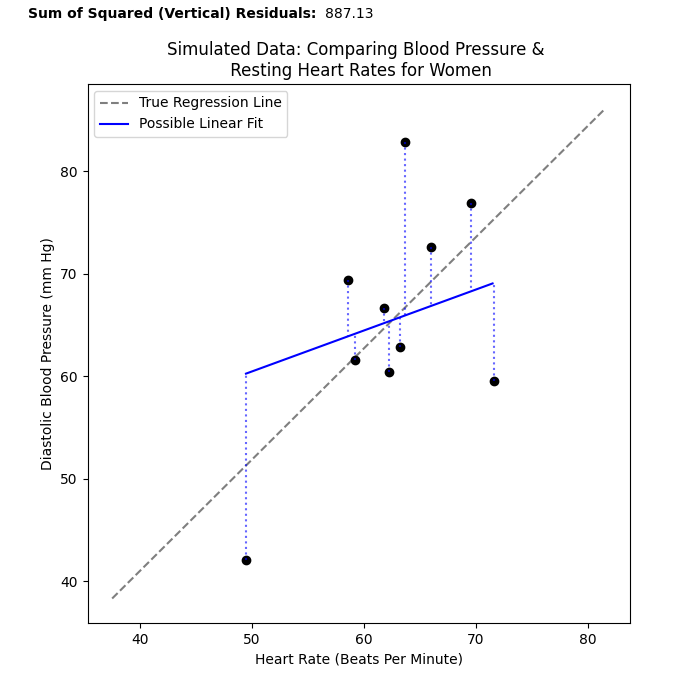

In [37]:
plt.close('all')
%matplotlib notebook
 
x_bar = np.mean(X[:,0])
y_bar = np.mean(X[:,1])

fig, ax = plt.subplots(figsize=(7,7))
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")

# Add data points
plt.scatter(X[:,0], X[:,1], color = 'black', alpha = 1)

plt.title("Simulated Data: Comparing Blood Pressure & \n Resting Heart Rates for Women")

x_axis = np.arange(np.min(X[:,0]), np.max(X[:,0]))
x_axis_full = np.arange(-25 + np.mean(X[:,0]), 20 + np.mean(X[:,0]))
# Force plot to look square
# ax.set_xlim(40,85)
# ax.set_ylim(40,85)

a, b       = np.polyfit(X[:,0], X[:, 1],1)
reg_line,  = ax.plot(x_axis_full, a*x_axis_full + b, linestyle = 'dashed', color = 'black', alpha = 0.5)
line,      = ax.plot(x_axis, a*x_axis + b, alpha = 1, color = 'blue')
ax.legend(['True Regression Line', 'Possible Linear Fit'], loc = 'upper left')
the_vlines = []

sum_of_vert_dists = make_vlines(X[:,0], X[:, 1], a, b)
# Display the sum of squared residuals
resid_label = 'Sum of Squared (Vertical) Residuals: '
plt.text(30,95, resid_label, weight='bold')
resid_pt = plt.text(56.5,95, '{:.2f}'.format(sum_of_vert_dists))

num_frames = 40

def animate(i):
    # During the last frame, snap to the true solution
    if i == num_frames - 1: curr_slope = a
    # Otherwise, iterate through possible slopes
    else: curr_slope = -2 + i/10
    # Center the potential fit line in the center of the cloud of data
    b = y_bar - curr_slope*x_bar
    line.set_ydata(curr_slope*x_axis + b)
    sum_of_vert_dists = make_vlines(X[:,0], X[:,1], curr_slope, b, first_run = False)
    resid_pt.set_text('{:.2f}'.format(sum_of_vert_dists))
    fig.canvas.draw_idle()

frames_lr = np.arange(0, num_frames)
# Pause the animation at the end before looping
frames_lr = np.append(frames_lr, (num_frames-1)*np.ones(20, dtype = np.int64))
# Create an animated GIF of this plot (optional)
ani = FuncAnimation(
    fig, animate, interval = 20, frames = frames_lr, blit = True, save_count = 50, repeat = True)

plt.show()

In [38]:
ani.save('lin_reg_uncentered.gif', writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.


In [29]:
def plot_orthog_projs_new(data_matrix, fit_line_vec, ax, first_run = True):
    total_sum_sqrs = 0
    plt_bnd_left        = 100
    plt_bnd_right       = -100
    # Iterate through the data to compute orthogonal projections
    for i in range(data_matrix.shape[0]):
        w               = data_matrix[i,:]
        cv              = np.dot(fit_line_vec,w)/(np.linalg.norm(fit_line_vec)**2)*fit_line_vec
        x_data          = [w[0],cv[0]]
        y_data          = [w[1],cv[1]]
        # Alternatively, could write as squared norm of vec (w - cv)
        sq_resid        = (x_data[1] - x_data[0])**2 + (y_data[1] - y_data[0])**2 
        total_sum_sqrs += sq_resid
        if first_run:
            proj, = ax.plot(x_data, y_data, linestyle = 'dotted', alpha = .6, color = 'red')
            proj_lines.append(proj)
        else:
            proj_lines[i].set_xdata(x_data)
            proj_lines[i].set_ydata(y_data)
        # Adjust plotting bounds
        # If the projection goes more to the left or the right than all the data points
        if cv[0] < plt_bnd_left: 
            plt_bnd_left = cv[0]
        if cv[0] > plt_bnd_right:
            plt_bnd_right = cv[0]
    step = 0.01
    plt_axis = np.arange(plt_bnd_left, plt_bnd_right + step, step)
    # Only give one of the projection lines a label, or else all of them will show up in the axis
    return(total_sum_sqrs, plt_axis)

In [ ]:
plt.close('all')
%matplotlib notebook
            
fig, ax = plt.subplots(figsize=(7,7))
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")

# Array for holding the orthogonal projections onto the fit line
proj_lines = []
            
# Add data points
plt.scatter(X_c[:,0],X_c[:,1], color = 'black', alpha = 1)

plt.title("Simulated Data (Centered): Comparing Blood Pressure & \n Resting Heart Rates for Women")

x_axis         = np.arange(np.min(X_c[:,0]), np.max(X_c[:,0]))
x_axis_full    = np.arange(-25, 20)

prin_comp_line = lambda x: prin_comp_vec[1]/prin_comp_vec[0]*x

# Plot the true component line
true_soln, = ax.plot(x_axis_full, prin_comp_line(x_axis_full), c = 'black', linestyle = 'dashed', alpha = 0.5, \
                    label = 'First Principal Component')
b         = prin_comp_line(0)

# Force plot to look square (give axes identical ranges)
# ax.set_xlim(-25,20)
# ax.set_ylim(-25,20)

ax.set_xlim(-40,30)
ax.set_ylim(-40,30)

# Plot orthogonal projections and get total sum of squares of error
total_sum_sqrs, x_axis_for_fit_line = plot_orthog_projs_new(X_c, prin_comp_vec, ax)

line, = ax.plot(x_axis_for_fit_line, prin_comp_line(x_axis_for_fit_line), c = 'red')


# # Display the sum of squared residuals
resid_label = 'Sum of Squared (Orthogonal) Residuals: '
plt.text(-49,39, resid_label, weight='bold')
resid_pt = plt.text(-7, 39, '{:.2f}'.format(total_sum_sqrs))

num_frames = 80

# Initialize slope to some arbitrary value to show possible fit lines (but assume fit line
# goes through)
# curr_slope = -2
# line_as_vec = np.array([X_c[0,0], curr_slope*X_c[0,0]])
# total_sum_sqrs, x_axis_for_fit_line  = plot_orthog_projs_new(X_c, line_as_vec, ax, False)

# line.set_xdata(x_axis_for_fit_line)
# line.set_ydata(curr_slope*x_axis_for_fit_line + b)

ax.legend([true_soln, line],['First Principal Component','Possible Linear Fit'], loc = 'upper left')

def animate(i):
    # During the last frame, snap to the true solution
    if i == num_frames - 1: curr_slope = prin_comp_vec[1]/prin_comp_vec[0]
    # Otherwise, iterate through possible slopes
    else: curr_slope = -2 + i/5
        
    line_as_vec = np.array([X_c[0,0], curr_slope*X_c[0,0]])
    total_sum_sqrs, x_axis_for_fit_line = plot_orthog_projs_new(X_c, line_as_vec, ax, False)
    line.set_xdata(x_axis_for_fit_line)
    line.set_ydata(curr_slope*x_axis_for_fit_line + b)
    resid_pt.set_text('{:.2f}'.format(total_sum_sqrs))
    fig.canvas.draw_idle()

frames = np.arange(0, num_frames)
# Pause the animation at the end before looping
frames = np.append(frames, (num_frames-1)*np.ones(20, dtype = np.int64))
# Create an animated GIF of this plot (optional)
ani = FuncAnimation(
    fig, animate, interval = 20, frames = frames, blit = True, save_count = 50, repeat = True)

plt.show()
# ani.save('pca_animation.gif', writer='imagemagick', fps=20)
# ani.save('pca_animation.gif', writer='Pillow', fps=40)

In [ ]:
ani.save('pca_animation.gif', writer='Pillow', fps=20, bitrate = 1000)